In [4]:
#imported libraries
import cv2
import imutils
import pytesseract
import matplotlib.pyplot as plt
import numpy as np
import easyocr
%matplotlib inline 




In [5]:
#path to which pytessearct is installed
pytesseract.pytesseract.tesseract_cmd = r'C:\Users\terry\anaconda3\Lib\site-packages\pytesseract'

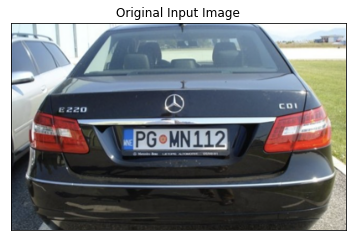

In [6]:
#function when reaing an image through opencv and displaying the image through plt
def displayfig(image, ucmap):
    #check image shape and number of channels
    if len(image.shape)==3 :
        # cv2.split function is used to split channels of colored image
        b,g,r = cv2.split(image)       # get b,g,r
        #merge the image into a colored image
        image = cv2.merge([r,g,b])  
    imgplot=plt.imshow(image, ucmap)
    #hide the x and y axis 
    imgplot.axes.get_xaxis().set_visible(False)
    imgplot.axes.get_yaxis().set_visible(False)
    #label the heading 
plt.title('Original Input Image')    
#read image using imread() function
plateimage = cv2.imread(r"C:\Users\terry\Documents\ResearchPaper\VehiclePlateCharacterRecognition\VehicleInputImage.png")
#show image
displayfig(plateimage, None)

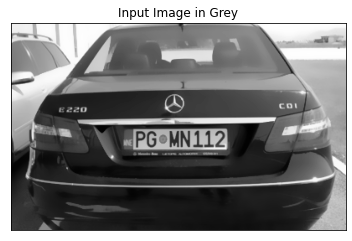

In [7]:
#convert the input image to greyscale
#label the heading 
plt.title('Input Image in Grey')
#recieves the origninal image as gray and the color space conversion code, 
#then cover the origninal image from the bgr color space to gray 
grayimage = cv2.cvtColor(plateimage,  cv2.COLOR_BGR2GRAY)
#reducing the noise in the grey image
grayimage = cv2.bilateralFilter(grayimage, 13, 15, 15)
#display input image
displayfig(grayimage, plt.get_cmap('gray'))

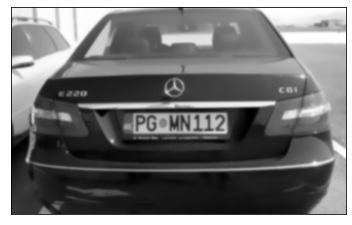

In [8]:
#remove noise by blurring with a gaussian filter
blurimage=cv2.GaussianBlur(grayimage,(5,5),0)
#show the blur image in gray
displayfig(blurimage, plt.get_cmap('gray'))

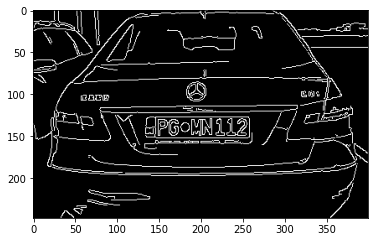

In [9]:
#removes noise while keeping edges sharp
bfilter = cv2.bilateralFilter(grayimage, 11, 17, 17) 
# detect the edge using canny edge function
edged = cv2.Canny(bfilter, 30, 200)
#display the image in gray with the edges
plt.imshow(cv2.cvtColor(edged, cv2.COLOR_BGR2RGB))

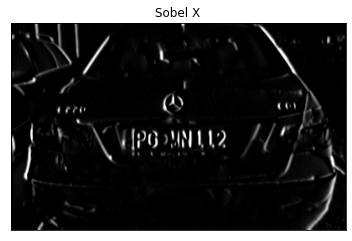

In [17]:
#using sobel operator to output the blur image 
#with the detected edges bright on a darker background with a kernel size of 3
#1 is x derivative direction
sobelx=cv2.Sobel(blurimage, cv2.CV_8U, 1, 0, ksize=3)
#label the heading
plt.title('Sobel X')
displayfig(sobelx, plt.get_cmap('gray'))

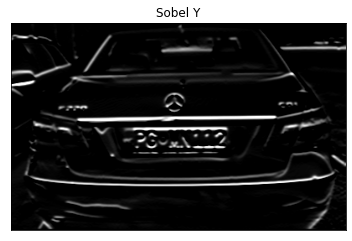

In [18]:
#using sobel operator to output the blur image 
#with the detected edges bright on a darker background with a kernel size of 3
#1 is y derivative direction 
sobely = cv2.Sobel(blurimage, cv2.CV_8U, 0,1, ksize=3)
#label the heading
plt.title('Sobel Y')
displayfig(sobely, plt.get_cmap('gray'))

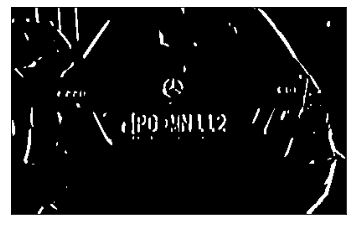

In [19]:
#Otsu threshold method is used to reveal the light regions in the 
#image to make the vehicle plate characters more visible in the x direction
lightmethod = cv2.threshold(sobelx, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
displayfig(lightmethod, plt.get_cmap('gray'))

In [21]:
# use otsu automatic thresholding that detects the best threshold value
(T,threshInv) = cv2.threshold(sobelx, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
print ("image above otsu's thresholding value: {}".format(T))

image above otsu's thresholding value: 75.0


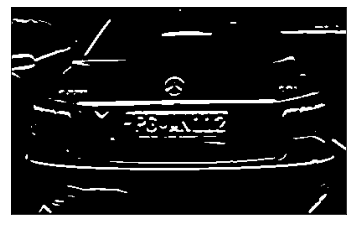

In [22]:
#Otsu threshold method is used to reveal the light regions in the image
#to make the vehicle plate characters more visible in the y direction
lightmethod = cv2.threshold(sobely, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
displayfig(lightmethod, plt.get_cmap('gray'))

In [23]:
# use otsu automatic thresholding that detects the best threshold value
(T,threshInv) = cv2.threshold(sobely, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
print ("image above otsu's thresholding value: {}".format(T))

image above otsu's thresholding value: 83.0


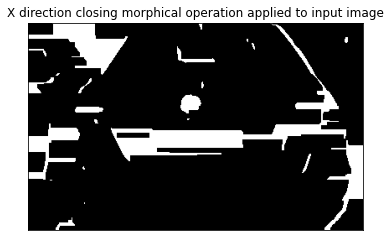

In [26]:
#use closing morphoical operation to remove the blank spaces between each vertical edge line , to identify possible regions that can contain the plate
#getStructuringElement() function is used to define the rectangluar element with a 34 x 5 to show the region of the plate
segment_inputimage=cv2.getStructuringElement(cv2.MORPH_RECT,(34,5))
#morphologyEx function is used to structure the image sizes
closing_operation=cv2.morphologyEx(lightmethod, cv2.MORPH_CLOSE, segment_inputimage)
#blur the gradient magnitude image
blurimage=cv2.GaussianBlur(grayimage,(5,5),0)
#using otsu method to threshold the image
lightmethod = cv2.threshold(sobelx, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
plt.title('X direction closing morphical operation applied to input image')
#display the image
displayfig(closing_operation, plt.get_cmap('gray'))

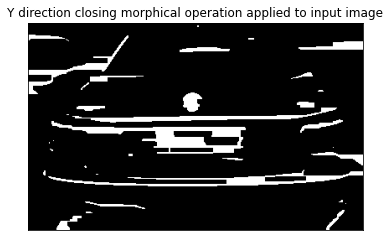

In [28]:
#use closing morphoical operation to remove the blank spaces between each vertical edge line , to identify possible regions that can contain the plate
#getStructuringElement() function is used to define the rectangluar element with a 34 x 5 to show the region of the plate
segment_inputimage=cv2.getStructuringElement(cv2.MORPH_RECT,(34,5))
#morphologyEx function is used to structure the image sizes
closing_operation=cv2.morphologyEx(lightmethod, cv2.MORPH_CLOSE, segment_inputimage)
#blur the gradient magnitude image
blurimage=cv2.GaussianBlur(grayimage,(5,5),0)
#using otsu method to threshold the image
lightmethod = cv2.threshold(sobely, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
plt.title('Y direction closing morphical operation applied to input image')
#display the image
displayfig(closing_operation, plt.get_cmap('gray'))

In [25]:
#After achieving the regions in the image that could identify as the vehicle plate , next step is to retrieve the cotonours of the threshold image 
#the contours are important to sort the region of the characters by its size in descending order, and keeping only the largest contours only the external contours are 
#important
keypoints = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
contour_inputimage = imutils.grab_contours(keypoints)
contour_inputimage = sorted(contour_inputimage, key=cv2.contourArea, reverse=True)[:10]

In [29]:
location = None
#for loop over the contours in the image
for count in contour_inputimage:
    #approximate the contour
    approx = cv2.approxPolyDP(count, 10, True)
    #statement used to see if the contour contains 4 points to find the location
    if len(approx) == 4:
        location = approx
        break

In [30]:
count

array([[[146, 128]],

       [[147, 127]],

       [[256, 127]],

       [[258, 129]],

       [[258, 150]],

       [[256, 152]],

       [[147, 152]],

       [[145, 150]],

       [[145, 148]],

       [[146, 147]],

       [[146, 140]],

       [[145, 139]],

       [[146, 138]]], dtype=int32)

In [32]:
# masks the part other than the license plate
mask = np.zeros(grayimage.shape, np.uint8)
#countour function
new_image = cv2.drawContours(mask, [approx], 0, 255, -1)
new_image = cv2.bitwise_and(plateimage, plateimage, mask=mask)

In [33]:
#mask and cropp the licese plate
(x,y) = np.where(mask==255)
(x1, y1) = (np.min(x), np.min(y))
(x2, y2) = (np.max(x), np.max(y))
cropped_image = grayimage[x1:x2+1, y1:y2+1]


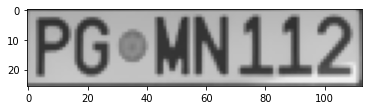

In [34]:
#show the image cropped in gray
plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))


In [45]:
# use cpu , ignore using gpu
reader = easyocr.Reader(['en'], gpu = False)
#read the numbers in the license plate
cropped_ocr_image_result = reader.readtext(cropped_image)
cropped_ocr_image_result

Using CPU. Note: This module is much faster with a GPU.


[([[0, 0], [113, 0], [113, 26], [0, 26]], 'PGoMN112', 0.6100236579409676)]

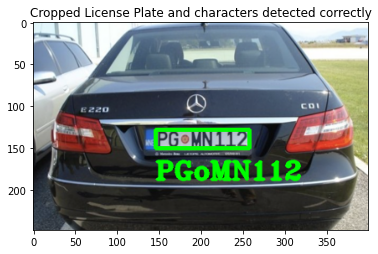

In [58]:
plt.title("Cropped License Plate and characters detected correctly")
text = cropped_ocr_image_result[0][-2]
font = cv2.FONT_HERSHEY_TRIPLEX
#print the characters of the license plate detected from the car 
finalresult=cv2.putText(plateimage, text=text, org=(approx[0][0][0], approx[1][0][1]+60), fontFace=font, fontScale=1, color=(0,255,0), thickness=2, lineType=cv2.LINE_AA)
finalresult = cv2.rectangle(plateimage, tuple(approx[0][0]), tuple(approx[2][0]), (0,255,0),3)
plt.imshow(cv2.cvtColor(finalresult, cv2.COLOR_BGR2RGB))       